In [66]:
import sys
sys.path.insert(0,'/nfs/nfs2/users/riadoshi/bigvision_palivla/dlimp')

import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

import tensorflow as tf

tf.config.set_visible_devices([], "GPU")

import jax

from absl import flags
import optax
import json
import numpy as np
import orbax.checkpoint as ocp
from tensorflow_text import SentencepieceTokenizer
import mediapy

from scalax.sharding import MeshShardingHelper, FSDPShardingRule, PartitionSpec
from jax.experimental import multihost_utils
from ml_collections import config_flags
from palivla.train_state import PaliVLATrainState
from palivla.palivla_types import RolloutBatch


from octo.data.oxe import make_oxe_dataset_kwargs
from octo.data.dataset import make_single_dataset

In [53]:
# load chunk of dataset in based on ID
print("Loading dataset *******")
DATASET_NAME = 'bridge_dataset'
dataset_kwargs = make_oxe_dataset_kwargs(DATASET_NAME,"gs://rail-orca-central2/resize_256_256/")
dataset = make_single_dataset(
                                dataset_kwargs, 
                                frame_transform_kwargs=dict(
                                    resize_size={"primary": (224, 224)},
                                ),
                                train=True)
iterator = dataset.iterator() # will default to no CoT

Loading dataset *******


In [3]:
# Reset flags if the cell is re-run
try:
    flags.FLAGS.unparse_flags()
except AttributeError:
    flags.FLAGS._flag_values_dict.clear()

# Define the config flag only if it hasn't been defined
if "config" not in flags.FLAGS:
    config_flags.DEFINE_config_file(
        "config", "/nfs/nfs2/users/riadoshi/bigvision_palivla/palivla/configs/bridge_config.py", "Path to the config file."
    )

import sys
flags.FLAGS(sys.argv, known_only=True)

config = flags.FLAGS.config

In [37]:

MODEL_PATH, MODEL_STEP = 'gs://multi-robot-bucket3/runs/vla/test_first_vla_run_final', 80000

with open(config.tokenizer_path, "rb") as f:
    language_tokenizer = SentencepieceTokenizer(f.read())

# Sharding
mesh = MeshShardingHelper([-1], ["fsdp"])


model_sharding = FSDPShardingRule("fsdp", fsdp_axis_size=mesh.mesh.shape["fsdp"])
data_sharding = PartitionSpec("fsdp")

optimizer = optax.identity()

print("Loading model params...")
restore_checkpoint_manager = ocp.CheckpointManager(
    MODEL_PATH,
    item_handlers=PaliVLATrainState.get_checkpoint_handlers(),
)
model = PaliVLATrainState.restore(
    checkpoint_manager=restore_checkpoint_manager,
    step=MODEL_STEP,
    load_optimizer=True,
    mesh=mesh,
    model_sharding=model_sharding,
    data_sharding=data_sharding
)


In [38]:
train_state = model.model_state

# Load dataset statistics
with tf.io.gfile.GFile(
    f"{MODEL_PATH}/{MODEL_STEP}/dataset_statistics/metadata", "r"
) as f:
    dataset_statistics = json.load(f)

with tf.io.gfile.GFile(
    f"{MODEL_PATH}/{MODEL_STEP}/config/metadata", "r"
) as f:
    loaded_config = json.load(f)

action_mean = np.array(dataset_statistics[DATASET_NAME]['action']["mean"])
action_std = np.array(dataset_statistics[DATASET_NAME]['action']["std"])


In [74]:
def prepare_images(images):
    return tf.convert_to_tensor([img  / 127.5 - 1.0 for img in images])

def do_inference(images, instructions):
    # images = prepare_images(images)
    batch_size = len(instructions)
    batch = {
        'tokens': [],
        'mask_ar': [],
        'mask_input': [],
        'action_start_idx': []
    }

    for l in instructions:
        l_tok = model.tokenizer.tokenize_language_instruction({'task': {'language_instruction': l}})
        res = model.tokenizer.prepare_tokens_for_generation(batch, l_tok, cot_tokens=None, training=False)
        batch["tokens"].append(res['tokens'])
        batch['mask_ar'].append(res['mask_ar'])
        batch['mask_input'].append(res['mask_input'])
        batch['action_start_idx'].append(res['action_start_idx'])


    batch = {
        k: v.numpy() if isinstance(v, tf.Tensor) else v for k, v in batch.items()
    }

    np_imgs = np.array([np.array(img) for img in images])

    mediapy.show_image(np_imgs[0].squeeze())
    sensors = {"image_primary": np_imgs}

    sensors_mask = {
        'image_primary': np.ones(np_imgs.shape[0], dtype=bool)
    }


    rollout_batch = RolloutBatch(
        sensor_data=sensors,
        sensor_masks=sensors_mask,
        prompt=np.array(batch['tokens']),
        prompt_mask=np.array(batch['mask_input']),
        prompt_ar=np.array(batch['mask_ar']),
    )

    batch = mesh.local_data_to_global_array(
        rollout_batch
    )

    out_tokens = model.decode(
        rollout_batch,
    )
    out_tokens = jax.device_get(multihost_utils.process_allgather(out_tokens))

    return out_tokens

    
def parse_out_tokens(out_tokens, action_dim=7):

    action_idx = np.where(out_tokens==model.tokenizer_config.begin_of_action_token)[0][0] + 1
    action_tokens = out_tokens[action_idx:action_idx+action_dim]
    decoded_actions = model.tokenizer.action_tokenizer.detokenize(action_tokens)
    decoded_actions = decoded_actions * action_std + action_mean

    cot_tokens = out_tokens[:action_idx]
    decoded_cot = model.language_tokenizer.detokenize(cot_tokens)

    return decoded_actions, decoded_cot

tf.Tensor(b'Move the can in the middle bottom of the table', shape=(), dtype=string)


""

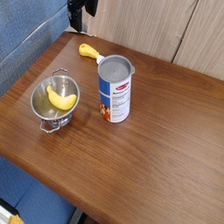

[[ 11839   2391 235248 ... 256192 256192 256192]
 [ 11839   2391 235248 ... 256192 256171 256180]
 [ 11839   2391 235248 ... 256192 256192 256128]
 ...
 [ 11839   2391 235248 ... 256128 256128 235289]
 [ 11839   2391 235248 ...   2161   8704   2391]
 [ 11839   2391 235248 ... 256616 235289    798]]


In [75]:
traj = next(iterator)

images = traj['observation']['image_primary'][:16]
# images = tf.zeros((1, 224, 224, 3), dtype=tf.uint8)
instructions = [tf.constant(traj['task']['language_instruction'][i].decode('utf-8')) for i in range(0,16)]
print(instructions[0])
assert instructions[0]!=""

out_tokens = do_inference(images, instructions)
print(out_tokens)

In [76]:
from data_generation.visualization.viz_helper import plot_gripper_plans, plot_object_plans

actions, reasoning = parse_out_tokens(out_tokens[10])
print((actions,reasoning))
print(traj['task']['language_instruction'][0])
traj['reasonings'] = [reasoning.numpy() for _ in range(len(traj['action']))]
plot_gripper_plans(traj, step=10)
plot_object_plans(traj, step=10)

[[nan nan nan nan nan nan nan]]
(Array([[nan, nan, nan, nan, nan, nan, nan]], dtype=float32), <tf.Tensor: shape=(), dtype=string, numpy=b'gripper <loc0205><loc0680>; can (in the middle bottom) <loc0000><loc0500><loc0184><loc0592><seg117><seg060><seg028><seg017><seg024><seg068><seg058><seg049><seg000><seg011><seg089><seg117><seg063><seg078><seg057><seg003>; gripper <loc0205><loc0680>; can (in the middle bottom) <loc0000><loc0492><loc0188><loc0592>; gripper <loc0207><loc0684>; can (in the middle bottom) <loc0000><loc0488><loc0184><loc0592>; gripper <loc0203><loc0684>; can (in the middle bottom) <loc0000><loc0488><loc0184><loc0592>; gripper <loc0203><loc0688>; can (in the middle bottom) <loc0000><loc0500><loc0188><loc0592>;\n'>)
b'Move the can in the middle bottom of the table'
[[51.25, 170.0], [51.25, 170.0], [51.75, 171.0], [50.75, 171.0], [50.75, 172.0]]


In [23]:
!sudo apt install ffmpeg -y


/nfs/nfs2/users/riadoshi/bigvision_palivla/uv/python/cpython-3.10.15-linux-x86_64-gnu/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmm-glib0 libnspr4 libnss3 libparted-fs-resize0 libudisks2-0
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  i965-va-driver intel-media-va-driver libaacs0 libaom0 libass9 libasyncns0
  libavc1394-0 libavcodec58 libavdevice58 libavfilter7 libavformat58
  libavresample4 libavutil56 libbdplus0 libbluray2 libbs2b0 libcaca0
  libcairo-gobject2 libcdio-cdda2 libcdio-paranoia2 libcdio18 libchromaprint1
  libcodec2-0.9 libdc1394-22 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfftw3-double3 libflac8 libflite1 libgdk-pixbuf2.0-0
  libgdk-pixbuf2.0-bin libgdk-pixbuf2.0-common l